In [1]:
import os
import shutil
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import seaborn as sns

print("TensorFlow version:", tf.__version__)
print("Available devices:", tf.config.list_physical_devices())
print("GPUs available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.10.1
Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
train_fake = len(os.listdir("real_vs_fake/real-vs-fake/train/fake"))
train_real = len(os.listdir("real_vs_fake/real-vs-fake/train/real"))
test_fake = len(os.listdir("real_vs_fake/real-vs-fake/test/fake"))
test_real = len(os.listdir("real_vs_fake/real-vs-fake/test/real"))
val_fake = len(os.listdir("real_vs_fake/real-vs-fake/valid/fake"))
val_real = len(os.listdir("real_vs_fake/real-vs-fake/valid/real"))

assert(train_fake == train_real)
assert(test_fake == test_real)
assert(val_fake == val_real)

print("Train total: ", train_fake + train_real)
print("Test total: ", test_fake + test_real)
print("Val total: ", val_fake + val_real)

Train total:  100000
Test total:  20000
Val total:  20000


In [3]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_dir = "real_vs_fake/real-vs-fake/train"
valid_dir = "real_vs_fake/real-vs-fake/valid"
test_dir = "real_vs_fake/real-vs-fake/test"

    # Setup generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(299, 299),  # Xception default input size
    batch_size=32,
    class_mode='binary',
    classes=["real", "fake"])

validation_generator = validation_datagen.flow_from_directory(
    valid_dir,
    target_size=(299, 299),
    batch_size=32,
    class_mode='binary',
    classes=["real", "fake"])

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(299, 299),
    batch_size=32,
    class_mode='binary',
    classes=["real", "fake"])

base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

    # Freeze the convolutional base
base_model.trainable = False

    # Add custom layers on top for binary classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)


Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [4]:
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)

Epoch 1/10
3125/3125 [==============================] - 1256s 400ms/step - loss: 0.5147 - accuracy: 0.7444 - val_loss: 0.4821 - val_accuracy: 0.7656
Epoch 2/10
3125/3125 [==============================] - 1246s 399ms/step - loss: 0.4564 - accuracy: 0.7830 - val_loss: 0.4145 - val_accuracy: 0.8092
Epoch 3/10
3125/3125 [==============================] - 1250s 400ms/step - loss: 0.4335 - accuracy: 0.7977 - val_loss: 0.3993 - val_accuracy: 0.8194
Epoch 4/10
3125/3125 [==============================] - 1259s 403ms/step - loss: 0.4138 - accuracy: 0.8084 - val_loss: 0.3617 - val_accuracy: 0.8422
Epoch 5/10
3125/3125 [==============================] - 1246s 399ms/step - loss: 0.4023 - accuracy: 0.8155 - val_loss: 0.3593 - val_accuracy: 0.8406
Epoch 6/10
3125/3125 [==============================] - 1257s 402ms/step - loss: 0.3932 - accuracy: 0.8208 - val_loss: 0.4000 - val_accuracy: 0.8202
Epoch 7/10
3125/3125 [==============================] - 1249s 399ms/step - loss: 0.3861 - accuracy: 0.8246

In [5]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy}, Test Loss: {test_loss}")

625/625 [==============================] - 132s 211ms/step - loss: 0.3308 - accuracy: 0.8535
Test Accuracy: 0.8534500002861023, Test Loss: 0.3308100402355194


625/625 [==============================] - 73s 116ms/step
              precision    recall  f1-score   support

        Fake       0.84      0.88      0.86     10000
        Real       0.87      0.83      0.85     10000

    accuracy                           0.85     20000
   macro avg       0.85      0.85      0.85     20000
weighted avg       0.85      0.85      0.85     20000



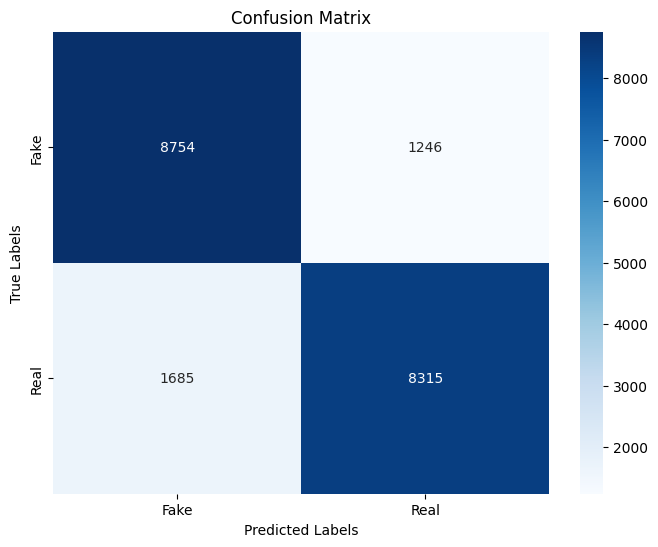

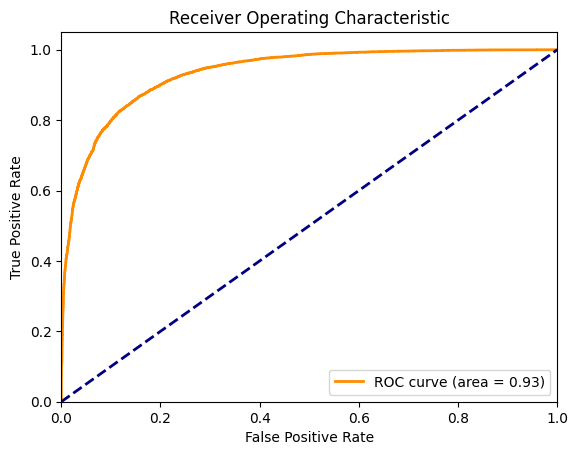

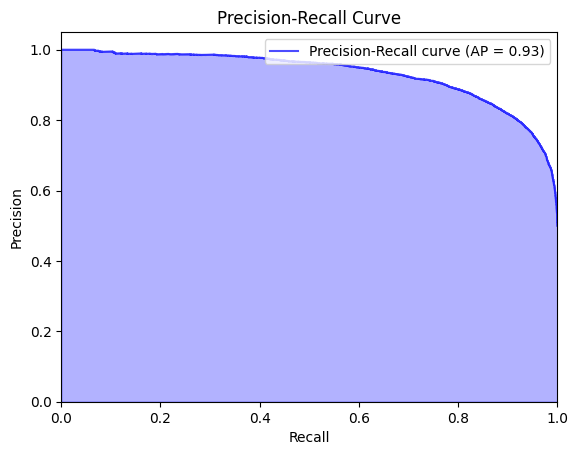

In [7]:
test_generator.shuffle = False 
test_generator.reset()

    # Run predictions
predictions = model.predict(test_generator)

    # Extract true labels from the test generator
true_labels = test_generator.classes

predicted_classes = (predictions > 0.5).astype(int)

report = classification_report(true_labels, predicted_classes, target_names=['Fake', 'Real'])
print(report)


cm = confusion_matrix(true_labels, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

    # ROC Curve
fpr, tpr, _ = roc_curve(true_labels, predictions)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
    
    # Precision-Recall Curve
precision, recall, _ = precision_recall_curve(true_labels, predictions)
average_precision = average_precision_score(true_labels, predictions)
plt.figure()
plt.step(recall, precision, where='post', color='b', alpha=0.7, label='Precision-Recall curve (AP = %0.2f)' % average_precision)
plt.fill_between(recall, precision, step='post', alpha=0.3, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()